# Erneuerbare Energien 12

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, savgol_filter

plt.style.use('science')
plt.rcParams.update({'font.size': 14})

# Photovoltaik Zelle

### Messung 1

In [4]:
# 2V -> 0.5% + 0.003
# 20V -> 0.5% + 0.03
# 200mA -> 1.5% + 0.3 
# 20mA -> 1% + 0.05
def uncert(values, mode='voltage'):
    uncert = []
    for v in values:
        if mode == 'voltage':
            if v > 2: uncert.append(0.005*v + 0.03)
            else: uncert.append(0.005*v + 0.003)
        if mode == 'current':
            if v > 19: uncert.append(0.015*v + 0.3) # hardcode for the rounding of 19.4 to be correct
            else: uncert.append(0.01*v + 0.05)
    return uncert

In [ ]:
# Bei abstand d = 30 cm
messung = ['links', 'rechts', 'parallel', 'serie']
U_leer = [1.160, 1.128, 1.127, 2.17] #V
I_kurz = [29.3, 29.6, 57.9, 31.2] #mA
dU = uncert(U_leer)
dI = uncert(I_kurz, 'current')


print(r'Messung & $U_{\text{leer}}$ / V & $I_{\text{kurz}}$ / mA \\')
for i in range(len(messung)):
    print(f'{messung[i]} & ${U_leer[i]:.2f} \\pm {dU[i]:.2f}$ & ${I_kurz[i]:.1f} \\pm {dI[i]:.2f}$ \\\\')

Messung & $U_{\text{leer}}$ / V & $I_{\text{kurz}}$ / mA \\
links & $1.16 \pm 0.01$ & $29.3 \pm 0.74$ \\
rechts & $1.13 \pm 0.01$ & $29.6 \pm 0.74$ \\
parallel & $1.13 \pm 0.01$ & $57.9 \pm 1.17$ \\
serie & $2.17 \pm 0.04$ & $31.2 \pm 0.77$ \\


### Messung 2 Abstand

In [40]:
# Wähle Schaltung: Serie
d = list(range(10, 110, 10)) # cm
dd = 0.1 #cm -> Entsprechend kleinser Skaleneinheit

U_leer = [2.39, 2.23, 2.17, 2.12, 2.10, 2.07, 2.04, 2.02, 2.00, 1.985]
I_kurz = [125.6, 56.4, 31.2, 19.4, 14.43, 10.86, 8.70, 7.19, 6.02, 5.18]

dU = uncert(U_leer)
dI = uncert(I_kurz, 'current')

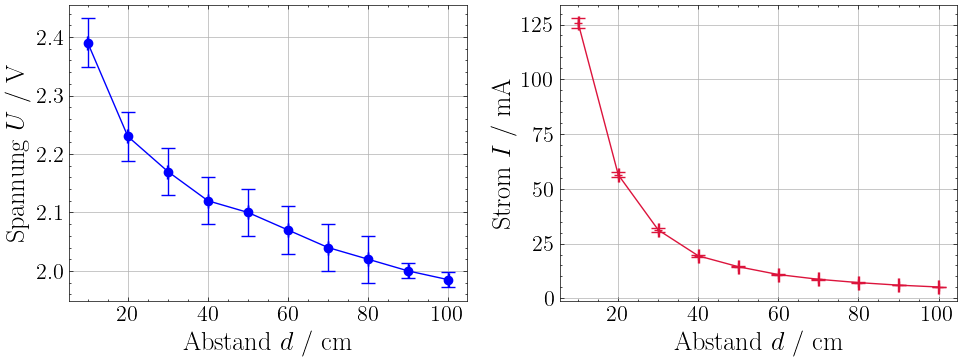

In [45]:
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(1,2, figsize=(10, 4))
  
axs[0].errorbar(x=d, y=U_leer, xerr=dd, yerr=dU, fmt='o-', color='blue', 
                capsize=5, label=r'$U_\text{leer}$')
axs[0].set_ylabel(r'Spannung $U$ / V', fontsize=19)
axs[1].errorbar(x=d, y=I_kurz, xerr=dd, yerr=dI, fmt='+-', color='crimson', 
                capsize=5, label=r'$I_\text{kurz}$')
axs[1].set_ylabel(r'Strom $I$ / mA', fontsize=19)

for i in range(2):
    ax = axs[i]
    ax.grid(True)
    ax.set_xlabel(r'Abstand $d$ / cm', fontsize=19)
plt.tight_layout()

# Brennstoffzelle

## Wirkungsgrad

In [17]:
U = 0.08
I = 15.4
dU = uncert([0.08])[0]
dI = uncert([15.4], 'current')[0]
t = 348
dt = 10

P = U* I
dP = P * (dU/U + dI/I)
print(P, dP)
E = P * t
dE = E * (dP/P +dt/t)
print(E,dE)

1.232 0.06868
428.736 36.22064


In [20]:
V = 2/1000 #l
dV = 0.2 /1000 #l

mol = 22.4135 #l/mol
H =  285.8 #kJ/mol

n = V/mol
dn = n*dV/V

E_c = H*n*1000
dE_c = E_c*dn/n
print(E_c, dE_c)

25.502487340219066 2.5502487340219067


In [25]:
E_e = E/1000
dE_e = dE/1000
eta = E_e/E_c
deta = eta* (dE_e/E_e + dE_c/E_c)
print(eta*100, deta*100)

1.6811536627011896 0.31014323797060883


## Kennlinie

In [43]:
def uncert2(values, mode='voltage', manual=0.01):
    uncert = []
    for v in values:
        if mode == 'voltage':
            if v > 2: uncert.append(0.005*v + 0.03)
            else: uncert.append(0.005*v + 0.003 + manual)
        if mode == 'current':
            if v > 19: uncert.append(0.015*v + 0.3) # hardcode for the rounding of 19.4 to be correct
            else: uncert.append(0.01*v + 0.05)
    return uncert

In [42]:
I_ohne = [4.11, 4.49, 4.90, 5.20, 5.54, 6.45, 7.54, 7.99, 8.76, 9.14, 10.90, 12.60, 14.80]
U_ohne = [0.855, 0.848, 0.839, 0.832, 0.825, 0.802, 0.781, 0.765, 0.727, 0.740, 0.703, 0.658, 0.500]

I_mit = [13.2, 11.2, 10.5, 7.8, 6.5, 7.2]
U_mit = [0.054, 0.044, 0.038, 0.030, 0.026]
U_add = 0.0135 

dI_ohne = uncert2(I_ohne, 'current')
dU_ohne = uncert2(U_ohne)

dI_mit = uncert2(I_mit, 'current')
dU_mit = uncert2(U_mit)
U_mit.append(U_add)
dU_mit.append(U_add*0.005 + 0.0003)
dU_mit

[0.01327, 0.01322, 0.01319, 0.01315, 0.01313, 0.0003675]

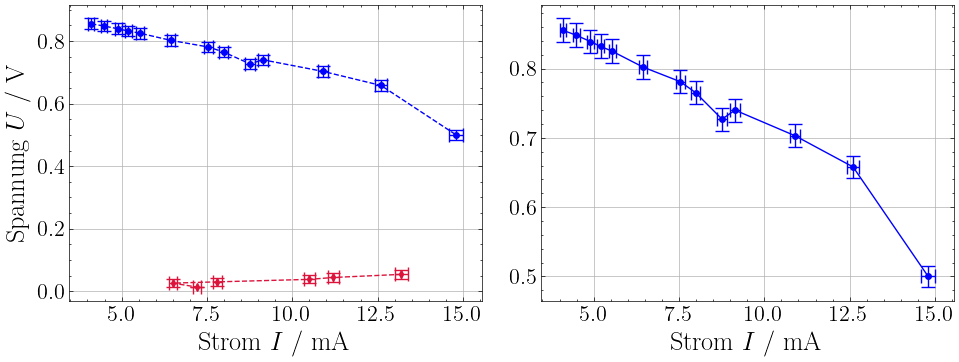

In [46]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1,2, figsize=(10, 4))
  
axs[0].errorbar(x=I_ohne, y=U_ohne, xerr=dI_ohne, yerr=dU_ohne, fmt='o--', color='blue', 
                capsize=5, label=r'Ohne Widerstand', markersize=4)

axs[1].errorbar(x=I_ohne, y=U_ohne, xerr=dI_ohne, yerr=dU_ohne, fmt='o-', color='blue', 
                capsize=5, label=r'Ohne Widerstand', markersize=4)

axs[0].errorbar(x=I_mit, y=U_mit, xerr=dI_mit, yerr=dU_mit, fmt='d--', color='crimson', 
                capsize=5, label=r'Mit Widerstand', markersize=4)

axs[0].set_ylabel(r'Spannung $U$ / V', fontsize=19)

for i in range(2):
    ax = axs[i]
    ax.grid(True)
    ax.set_xlabel(r'Strom $I$ / mA', fontsize=19)



plt.tight_layout()

k = -0.023605459548392143 pm 0.0010239190324435722
d = 0.9537303413551996 pm 0.008455135057206336


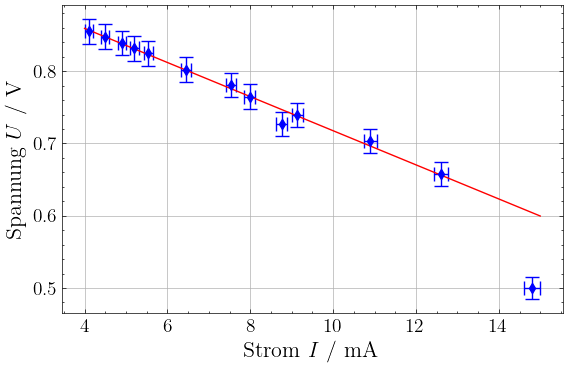

In [33]:
def ffit(x, k, d):
    return k*x + d

popt,pcov = curve_fit(ffit, I_ohne[2:-1], U_ohne[2:-1])
fit_uncert = np.sqrt(np.diag(pcov))

I_fit = np.linspace(4, 15, 1000)
U_fit = ffit(I_fit, *popt)

fig, ax = plt.subplots(1,1, figsize=(6, 4))

ax.errorbar(x=I_ohne, y=U_ohne, xerr=dI_ohne, yerr=dU_ohne, fmt='d', color='blue', 
                capsize=5, label=r'Messdaten', markersize=5)
ax.plot(I_fit, U_fit, color='red', label='linearer Fit')

ax.set_ylabel(r'Spannung $U$ / V', fontsize=16)

ax.grid(True)
ax.set_xlabel(r'Strom $I$ / mA', fontsize=16)

plt.tight_layout()
print(f"k = {popt[0]} pm {fit_uncert[0]}")
print(f"d = {popt[1]} pm {fit_uncert[1]}")

a = -0.020431567623571782 pm 0.003905384551294513
b = 0.9016826315165496 pm 0.06713042903421788
c = 0.19485870900171048 pm 0.2701784999671257


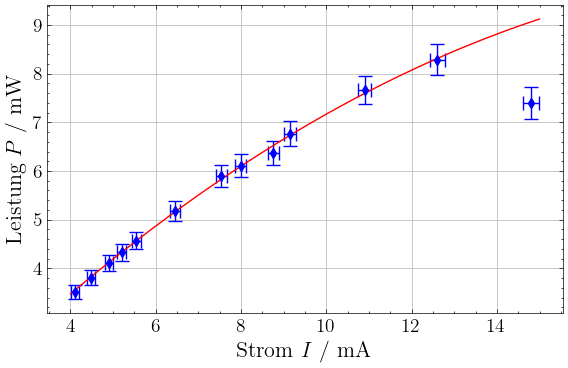

In [36]:
def ffit(x, a, b, c):
    return a*x**2+ b*x + c

U = np.array(U_ohne)
I = np.array(I_ohne)
dU = np.array(dU_ohne)
dI = np.array(dI_ohne)

P = U*I
dP = P * (dU/U + dI/I)
popt,pcov = curve_fit(ffit, I[2:-1], P[2:-1])
fit_uncert = np.sqrt(np.diag(pcov))

I_fit = np.linspace(4, 15, 1000)
P_fit = ffit(I_fit, *popt)

fig, ax = plt.subplots(1,1, figsize=(6, 4))

ax.errorbar(x=I, y=P, xerr=dI, yerr=dP, fmt='d', color='blue', 
                capsize=5, label=r'Messdaten', markersize=5)
ax.plot(I_fit, P_fit, color='red', label='quadratischer Fit')
ax.set_ylabel(r'Leistung $P$ / mW', fontsize=16)

ax.grid(True)
ax.set_xlabel(r'Strom $I$ / mA', fontsize=16)

plt.tight_layout()
print(f"a = {popt[0]} pm {fit_uncert[0]}")
print(f"b = {popt[1]} pm {fit_uncert[1]}")
print(f"c = {popt[2]} pm {fit_uncert[2]}")

# Windkraft

3.6780654594207474


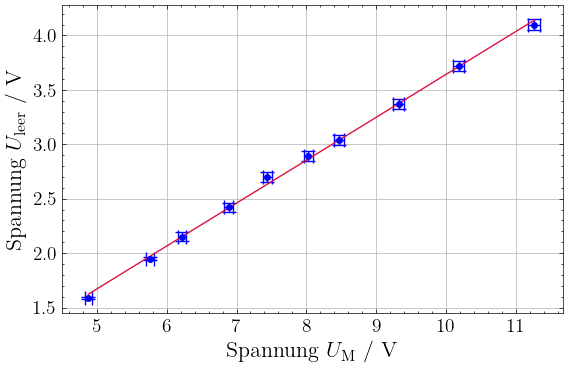

In [37]:
# fester Abstand d=5cm pm 0.1

U_m = [4.88, 5.76, 6.22, 6.89, 7.44, 8.03, 8.47, 9.32, 10.18, 11.26]
U_leer = [1.588, 1.95, 2.15, 2.42, 2.70, 2.89, 3.04, 3.37, 3.72, 4.10]

def ffit(x, k, d):
    return k*x + d

popt,pcov = curve_fit(ffit, U_m, U_leer)
fit_uncert = np.sqrt(np.diag(pcov))

U_mfit = np.linspace(min(U_m), max(U_m), 1000)
U_leer_fit = ffit(U_mfit, *popt)

dU_m = uncert(U_m)
dU_leer = uncert(U_leer)

fig, ax = plt.subplots(1,1, figsize=(6, 4))

ax.errorbar(x=U_m, y=U_leer, xerr=dU_m, yerr=dU_leer, fmt='o', color='blue', 
                capsize=5, label=r'Messdaten', markersize=4)
ax.plot(U_mfit, U_leer_fit, linestyle='-', color='crimson', label='linearer Fit')
ax.set_ylabel(r'Spannung $U_\text{leer}$ / V', fontsize=16)

ax.grid(True)
ax.set_xlabel(r'Spannung $U_\text{M}$ / V', fontsize=16)

plt.tight_layout()
print(ffit(10.09, *popt))

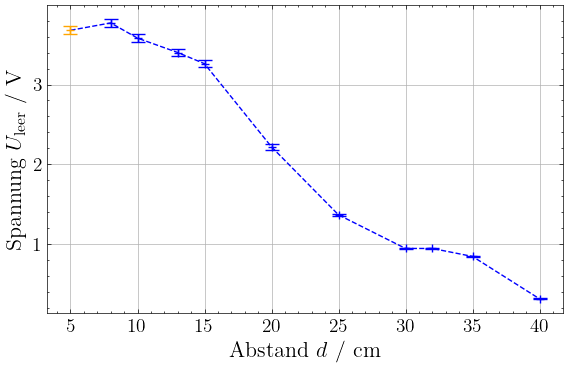

In [5]:
d = [10, 20, 30, 40, 15, 25, 35, 13, 8, 32, 5]
U_leer = [3.58, 2.22, 0.95, 0.32, 3.26, 1.37, 0.85, 3.40, 3.77, 0.95, 3.678]

sorted_indices = np.argsort(d)
d_sorted = np.array(d)[sorted_indices]
U_sorted = np.array(U_leer)[sorted_indices]
dd = 0.1
dU_leer = uncert(U_leer)

fig, ax = plt.subplots(1,1, figsize=(6, 4))

ax.errorbar(x=d[:-1], y=U_leer[:-1], yerr=dU_leer[:-1], fmt='+', color='blue', 
                capsize=5, label=r'Messdaten')
ax.errorbar(x=d[-1], y=U_leer[-1], yerr=dU_leer[-1], fmt='+', color='orange', 
                capsize=5, label=r'berechnete Werte')


ax.plot(d_sorted, U_sorted, 'b--')
ax.set_ylabel(r'Spannung $U_\text{leer}$ / V', fontsize=16)

ax.grid(True)
ax.set_xlabel(r'Abstand $d$ / cm', fontsize=16)

plt.tight_layout()

## Kapazität

## Brenstoffzelle als Speicher

0.5526347436792349 0.03815616702269501


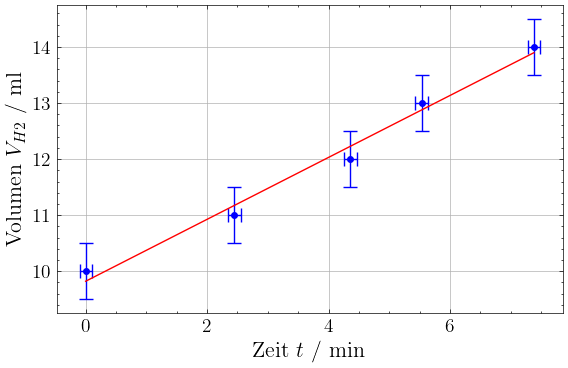

In [38]:
def ffit(t, k, d):
    return k*t + d

V = [10, 11, 12, 13, 14] # ml
t = [0, 2.45, 4.36, 5.53, 7.38]

dV = 0.5
dt = 0.1
t_fit = np.linspace(0, 7.38, 1000)

popt, pcov = curve_fit(ffit, t, V)
V_fit = ffit(t_fit, *popt)
fit_param = np.sqrt(np.diag(pcov))
fig, ax = plt.subplots(1,1, figsize=(6, 4))

ax.errorbar(x=t, y=V, xerr=dt, yerr=dV, fmt='o', color='blue', 
                capsize=5, label=r'Messdaten', markersize=4)
ax.plot(t_fit, V_fit, 'r-', label=r'linearer Fit')
ax.set_ylabel(r'Volumen $V_{H2}$ / ml', fontsize=16)
ax.grid(True)
ax.set_xlabel(r'Zeit $t$ / min', fontsize=16)
print(popt[0],fit_param[0])
plt.tight_layout()